In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/PFA/kaggle.json ~/.kaggle/kaggle.json 

In [ ]:
!kaggle datasets download -d risangbaskoro/wlasl-processed

100% 4.82G/4.82G [00:45<00:00, 91.9MB/s]
100% 4.82G/4.82G [00:45<00:00, 114MB/s] 


In [ ]:
!kaggle datasets download -d risangbaskoro/wlasl-processed

100% 4.81G/4.82G [00:32<00:00, 194MB/s]
100% 4.82G/4.82G [00:32<00:00, 160MB/s]


In [ ]:
ls

 Dataset/
 kaggle.json
'Real Time Streaming Transcription Speech to Text with Deep speech'
'Sign Language Detection using ACTION RECOGNITION with Python | LSTM Deep Learning Model'
'Speech Recognition'
'Speech to Text with Deep speech'
'Task 3 - sign to text'/
 wlasl-classification.ipynb
 wlasl-processed.zip


In [ ]:
! unzip wlasl-processed.zip -d wlasl-processed

Streaming output truncated to the last 5000 lines.
  inflating: wlasl-processed/videos/43596.mp4  
  inflating: wlasl-processed/videos/43598.mp4  
  inflating: wlasl-processed/videos/43599.mp4  
  inflating: wlasl-processed/videos/43671.mp4  
  inflating: wlasl-processed/videos/43672.mp4  
  inflating: wlasl-processed/videos/43674.mp4  
  inflating: wlasl-processed/videos/43677.mp4  
  inflating: wlasl-processed/videos/43679.mp4  
  inflating: wlasl-processed/videos/43680.mp4  
  inflating: wlasl-processed/videos/43681.mp4  
  inflating: wlasl-processed/videos/43682.mp4  
  inflating: wlasl-processed/videos/43684.mp4  
  inflating: wlasl-processed/videos/43689.mp4  
  inflating: wlasl-processed/videos/43697.mp4  
  inflating: wlasl-processed/videos/43698.mp4  
  inflating: wlasl-processed/videos/43700.mp4  
  inflating: wlasl-processed/videos/43703.mp4  
  inflating: wlasl-processed/videos/43726.mp4  
  inflating: wlasl-processed/videos/43727.mp4  
  inflating: wlasl-processed/videos/4

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# main json file >>> /kaggle/input/wlasl-processed/WLASL_v0.3.json

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **<font style="color:#112B3C"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [ ]:
pip install ez_setup

In [ ]:
pip install moviepy

In [ ]:
!pip install pafy

In [ ]:
!pip install youtube-dl

In [ ]:
pip install youtube-dl==2020.12.2

In [ ]:
# import required libraries
import json
import os
import cv2
import pandas as pd
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

 ### **<font style="color:#112B3C">Load WLAS Dataset</font>**

In [ ]:
main_path = '/kaggle/input/wlasl-processed/'
wlas_df = pd.read_json(main_path + 'WLASL_v0.3.json')

In [ ]:
wlas_df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [ ]:
wlas_df.shape

(2000, 2)

### **<font style="color:#112B3C">Extract the available videos list from the dataset</font>**

In [ ]:
def get_videos_ids(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids of the current instance
    
    input: instance json list
    output: list of videos_ids
    
    """
    videos_list = []    
    for ins in json_list:
        video_id = ins['video_id']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_list.append(video_id)
    return videos_list

In [ ]:
def get_json_features(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids and url or any other featrue of the current instance
    
    input: instance json list
    output: list of videos_ids
    
    """
    videos_ids = []
    videos_urls = []
    for ins in json_list:
        video_id = ins['video_id']
        video_url = ins['url']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_ids.append(video_id)
            videos_urls.append(video_url)
    return videos_ids, videos_urls

In [ ]:
with open(main_path+'WLASL_v0.3.json', 'r') as data_file:
    json_data = data_file.read()

instance_json = json.loads(json_data)

In [ ]:
get_videos_ids(instance_json[0]['instances'])[0]

'69241'

In [ ]:
len(get_videos_ids(instance_json[0]['instances']))

6

In [ ]:
wlas_df['videos_ids'] = wlas_df['instances'].apply(get_videos_ids)

In [ ]:
features_df = pd.DataFrame(columns=['gloss', 'video_id', 'url'])
for row in wlas_df.iterrows():
#     print(row[1][1])
    ids, urls = get_json_features(row[1][1])
    word = [row[1][0]] * len(ids)
    df = pd.DataFrame(list(zip(word, ids, urls)), columns = features_df.columns)
    features_df = features_df.append(df, ignore_index=True)

In [ ]:
features_df.index.name = 'index'
features_df

,gloss,video_id,url
index,,,
0,book,69241,http://aslbricks.org/New/ASL-Videos/book.mp4
1,book,07069,https://signstock.blob.core.windows.net/signsc...
2,book,07068,https://s3-us-west-1.amazonaws.com/files.start...
3,book,07070,https://media.asldeafined.com/vocabulary/14666...
4,book,07099,http://www.aslsearch.com/signs/videos/book.mp4
...,...,...,...
11975,wheelchair,63047,https://www.signingsavvy.com/signs/mp4/5/5233.mp4
11976,wheelchair,63050,http://www.aslsearch.com/signs/videos/wheelcha...
11977,whistle,63186,https://media.spreadthesign.com/video/mp4/13/9...


In [ ]:
# save to csv
#features_df.to_csv('features_df.csv', index=False)

## **<font style="color:#112B3C">Explore the Data</font>**

In [ ]:
wlas_df.head()

,gloss,instances,videos_ids
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...","[69241, 07069, 07068, 07070, 07099, 07074]"
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...","[69302, 65539, 17710, 17733, 65540, 17734, 177..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[12328, 12312, 12311, 12338, 12313, 12314, 123..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[05728, 05749, 05750, 05729, 05730, 65167, 057..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[09848, 09869, 09849, 09850, 09851, 65328, 09854]"


## **<font style="color:#205375">Dataset Classes analysis</font>**

In [ ]:
wlas_df['samples_num'] = wlas_df['videos_ids'].apply(len)

In [ ]:
wlas_df.head()

In [ ]:
print("minimum number of samples for a word:", wlas_df['samples_num'].min())
print("maximum number of samples for a word:", wlas_df['samples_num'].max())

In [ ]:
words_sample_counts = wlas_df[['gloss', 'samples_num']].groupby('samples_num').agg({"gloss":['count', ', '.join]})

In [ ]:
words_sample_counts

In [ ]:
# the words that have two samples
words_sample_counts.loc[2].values[1]

### **<font style="color:#205375">Visualize the Data with its Labels</font>**

In [ ]:
features_df

,gloss,video_id,url
index,,,
0,book,69241,http://aslbricks.org/New/ASL-Videos/book.mp4
1,book,07069,https://signstock.blob.core.windows.net/signsc...
2,book,07068,https://s3-us-west-1.amazonaws.com/files.start...
3,book,07070,https://media.asldeafined.com/vocabulary/14666...
4,book,07099,http://www.aslsearch.com/signs/videos/book.mp4
...,...,...,...
11975,wheelchair,63047,https://www.signingsavvy.com/signs/mp4/5/5233.mp4
11976,wheelchair,63050,http://www.aslsearch.com/signs/videos/wheelcha...
11977,whistle,63186,https://media.spreadthesign.com/video/mp4/13/9...


In [ ]:
# get all categories classes
all_classes = features_df.gloss.value_counts().keys().to_list()
all_classes

['cool',
 'before',
 'thin',
 'go',
 'drink',
 'help',
 'who',
 'cousin',
 'computer',
 'candy',
 'tall',
 'accident',
 'thanksgiving',
 'short',
 'trade',
 'bowling',
 'bed',
 'dark',
 'what',
 'last',
 'corn',
 'change',
 'cold',
 'shirt',
 'call',
 'man',
 'later',
 'basketball',
 'pizza',
 'yes',
 'champion',
 'environment',
 'letter',
 'room',
 'thursday',
 'apple',
 'bar',
 'laugh',
 'delay',
 'score',
 'play',
 'brother',
 'check',
 'take',
 'soon',
 'far',
 'woman',
 'why',
 'example',
 'leave',
 'walk',
 'no',
 'deaf',
 'family',
 'dog',
 'mother',
 'convince',
 'wait',
 'snow',
 'because',
 'tell',
 'good',
 'move',
 'perspective',
 'silly',
 'sweet',
 'balance',
 'son',
 'daughter',
 'delicious',
 'appointment',
 'fat',
 'cry',
 'government',
 'argue',
 'blanket',
 'bad',
 'theory',
 'yesterday',
 'write',
 'sandwich',
 'interest',
 'order',
 'ready',
 'full',
 'give',
 'fish',
 'orange',
 'many',
 'like',
 'hot',
 'secretary',
 'speech',
 'black',
 'bird',
 'work',
 'doctor

In [ ]:
classes_dict = {}
for i in range(len(all_classes)):
    classes_dict[all_classes[i]] = i

classes_dict

{'cool': 0,
 'before': 1,
 'thin': 2,
 'go': 3,
 'drink': 4,
 'help': 5,
 'who': 6,
 'cousin': 7,
 'computer': 8,
 'candy': 9,
 'tall': 10,
 'accident': 11,
 'thanksgiving': 12,
 'short': 13,
 'trade': 14,
 'bowling': 15,
 'bed': 16,
 'dark': 17,
 'what': 18,
 'last': 19,
 'corn': 20,
 'change': 21,
 'cold': 22,
 'shirt': 23,
 'call': 24,
 'man': 25,
 'later': 26,
 'basketball': 27,
 'pizza': 28,
 'yes': 29,
 'champion': 30,
 'environment': 31,
 'letter': 32,
 'room': 33,
 'thursday': 34,
 'apple': 35,
 'bar': 36,
 'laugh': 37,
 'delay': 38,
 'score': 39,
 'play': 40,
 'brother': 41,
 'check': 42,
 'take': 43,
 'soon': 44,
 'far': 45,
 'woman': 46,
 'why': 47,
 'example': 48,
 'leave': 49,
 'walk': 50,
 'no': 51,
 'deaf': 52,
 'family': 53,
 'dog': 54,
 'mother': 55,
 'convince': 56,
 'wait': 57,
 'snow': 58,
 'because': 59,
 'tell': 60,
 'good': 61,
 'move': 62,
 'perspective': 63,
 'silly': 64,
 'sweet': 65,
 'balance': 66,
 'son': 67,
 'daughter': 68,
 'delicious': 69,
 'appointment

In [ ]:
features_df['gloss_indx'] = features_df.gloss.map(classes_dict)

In [ ]:
features_df

,gloss,video_id,url,gloss_indx
index,,,,
0,book,69241,http://aslbricks.org/New/ASL-Videos/book.mp4,878
1,book,07069,https://signstock.blob.core.windows.net/signsc...,878
2,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,878
3,book,07070,https://media.asldeafined.com/vocabulary/14666...,878
4,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,878
...,...,...,...,...
11975,wheelchair,63047,https://www.signingsavvy.com/signs/mp4/5/5233.mp4,1588
11976,wheelchair,63050,http://www.aslsearch.com/signs/videos/wheelcha...,1588
11977,whistle,63186,https://media.spreadthesign.com/video/mp4/13/9...,1979


> *let's initialize some constants*

In [ ]:
# Specify the hight and width each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the dataset.
DATASET_DIR = "/kaggle/input/wlasl-processed/videos/"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = all_classes

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

In [ ]:
def get_index_of_video(vd_id):
    i = 0
    for item in features_df["video_id"]:
        if item == vd_id:
            break
        i = i+1
    return i

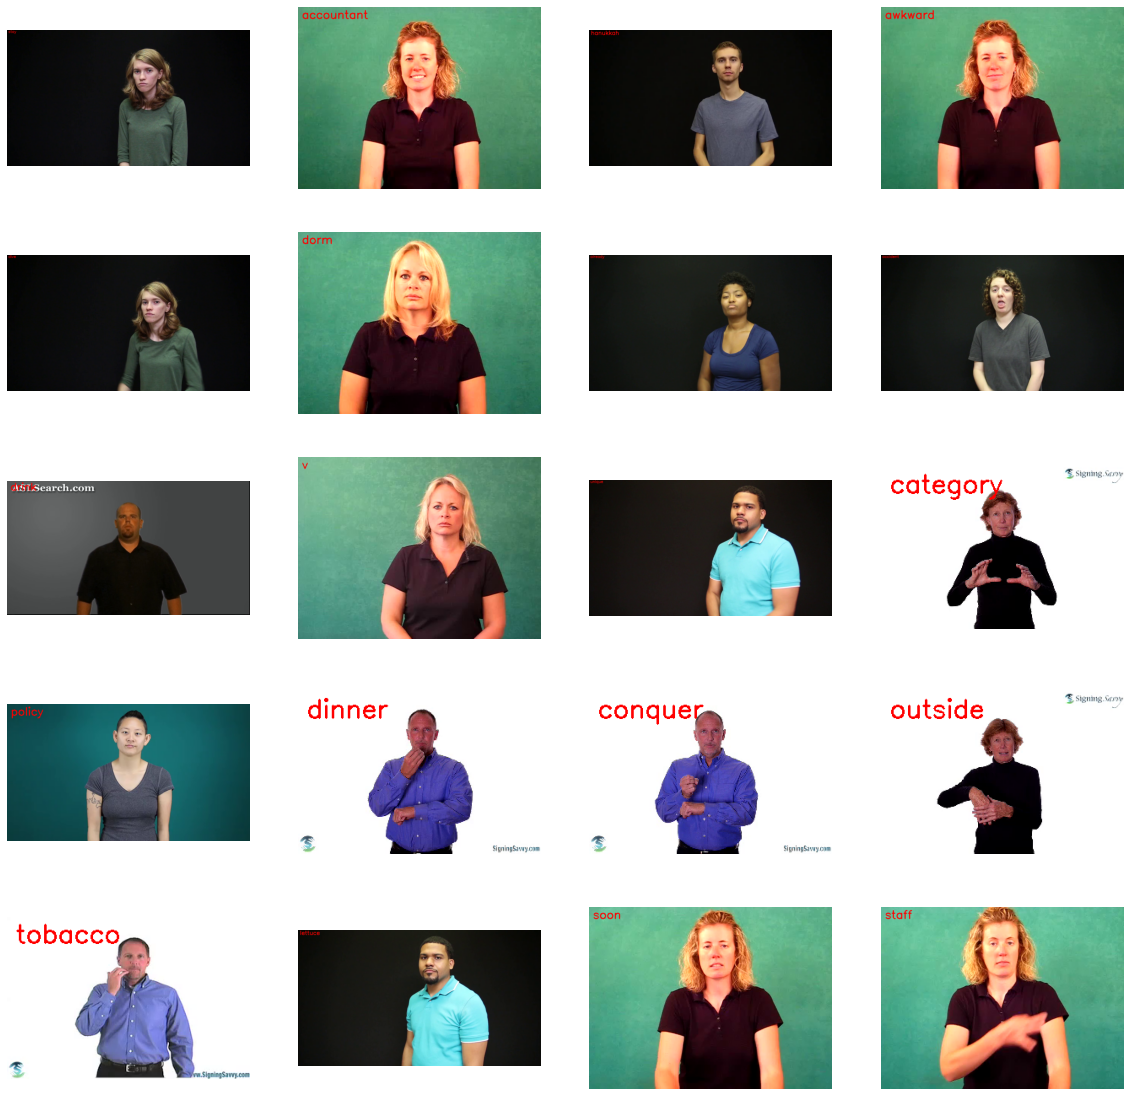

In [ ]:
# Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories in UCF50
all_classes_names = os.listdir(DATASET_DIR)

# generate a list of 20 random values. The values will be between 0-50 where 50 is the
# total number of classes in the dataset
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve the list of all the video files present in the randomly selected Class Directory
    video_files_names_list = os.listdir(DATASET_DIR)

    #Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
    
    # Retrieve a Class Name using the Random Index.
    idx = get_index_of_video(selected_video_file_name.split(".")[0])
    selected_class_Name = features_df.iloc[idx].gloss

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{DATASET_DIR}{selected_video_file_name}')

    # Read the first frame of the video file
    _, bgr_frame = video_reader.read()

    # release the video object
    video_reader.release()

    #  convert the frame from VGR into RBG format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Display the frame
    plt.subplot(5, 4, counter); plt.imshow(rgb_frame);plt.axis('off')
   


## **<font style="color:#112B3C">Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

### **<font style="color:#205375">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames. 

In [ ]:
def frames_extraction(video_path):
    """
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
    video_path: The path of the video in the disk, whose frames are to be extracted.

    Returns:
    frames_list: A list containing the resized and normalized frames of the video.
    """

    # Declare a list to store video frames.
    frames_list = []

    # Read the video File using the videoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video frames:
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # check if the video frame is not successfully read the break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies wetween 0 and 1
        normalized_frame = resized_frame / 255 

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # return the frames list.
    return frames_list


### **<font style="color:#205375">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the video located in the **`DATASET_DIR`** constant and will call the function  **`frame_extraction()`** on every video file and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [ ]:
def create_dataset():
    """
    This function will extract the data of the videos and create the required dataset.
    Retuns:
    features: A list containing the extracted frames of the videos.
    labels :  A list containing the indexes of the classes associated with the video
    video_files_paths :  A list containing the paths of the videos in the disk.
    """

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
       

    # Get the list of video files present in the specific class name directory.
    files_list = os.listdir(DATASET_DIR)
    count = 0
    for file_name in files_list:

        # Display the name of the video whose data is being extracted and its number in iterations
        print(f"Extracting Data of file: {file_name}, number: {count}")

        # Get the complete video path.
        video_file_path = os.path.join(DATASET_DIR, file_name)

        # Extract the frames of the video file.
        frames = frames_extraction(video_file_path)

        # check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
        # So ignore the videos having less than the SEQUENCE_LENGTH.
        if len(frames) == SEQUENCE_LENGTH:

            # Append the data to their repective list
            features.append(frames)
            # get the video's class name
            idx = get_index_of_video(file_name.split(".")[0])
            class_index = features_df.iloc[idx].gloss_indx
            labels.append(class_index)
            video_files_paths.append(video_file_path)
            count = count +1
            if count > 1000:
                break

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class_index and video_file_path
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data and create the required dataset.

In [ ]:
# Creat the dataset
features, labels, video_file_path = create_dataset()

Extracting Data of file: 03238.mp4, number: 0
Extracting Data of file: 19110.mp4, number: 1
Extracting Data of file: 24027.mp4, number: 2
Extracting Data of file: 65091.mp4, number: 3
Extracting Data of file: 08595.mp4, number: 4
Extracting Data of file: 56178.mp4, number: 5
Extracting Data of file: 57934.mp4, number: 6
Extracting Data of file: 32478.mp4, number: 7
Extracting Data of file: 54425.mp4, number: 8
Extracting Data of file: 42670.mp4, number: 9
Extracting Data of file: 59051.mp4, number: 10
Extracting Data of file: 65405.mp4, number: 11
Extracting Data of file: 30278.mp4, number: 12
Extracting Data of file: 03318.mp4, number: 13
Extracting Data of file: 39118.mp4, number: 14
Extracting Data of file: 45656.mp4, number: 15
Extracting Data of file: 30271.mp4, number: 16
Extracting Data of file: 65340.mp4, number: 17
Extracting Data of file: 52713.mp4, number: 18
Extracting Data of file: 01962.mp4, number: 19
Extracting Data of file: 18856.mp4, number: 20
Extracting Data of file

In [ ]:
from numpy import asarray
from numpy import savetxt


In [ ]:
import pickle


output = open('features.pkl', 'wb')
pickle.dump(features, output)
output.close()

In [ ]:
import pprint, pickle

pkl_file = open('features.pkl', 'rb')

data1 = pickle.load(pkl_file)
pprint.pprint(data1)

pkl_file.close()

array([[[[[0.50588235, 0.64313725, 0.36470588],
          [0.48627451, 0.63529412, 0.35294118],
          [0.49411765, 0.6627451 , 0.37647059],
          ...,
          [0.49411765, 0.6627451 , 0.37647059],
          [0.49019608, 0.65882353, 0.37254902],
          [0.4745098 , 0.64313725, 0.35686275]],

         [[0.49411765, 0.63137255, 0.35294118],
          [0.48235294, 0.63137255, 0.34901961],
          [0.47058824, 0.63921569, 0.35294118],
          ...,
          [0.47843137, 0.64705882, 0.36078431],
          [0.4627451 , 0.63137255, 0.34509804],
          [0.4627451 , 0.63137255, 0.34509804]],

         [[0.48235294, 0.63137255, 0.34901961],
          [0.4627451 , 0.63921569, 0.35294118],
          [0.47058824, 0.64705882, 0.34117647],
          ...,
          [0.47058824, 0.65098039, 0.33333333],
          [0.45490196, 0.63921569, 0.33333333],
          [0.45882353, 0.64313725, 0.3372549 ]],

         ...,

         [[0.32941176, 0.45098039, 0.14117647],
          [0.32941176,

## **<font style="color:#112B3C">Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
len(set(labels)), len(set(labels_train)), len(set(labels_test))

(807, 640, 242)

In [ ]:
NB_CLASSES = len(set(labels_train))
NB_CLASSES

640

Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [ ]:
labels_train = tf.one_hot(labels_train, NB_CLASSES)

2022-05-03 12:44:23.269610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 12:44:23.382249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 12:44:23.382956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 12:44:23.385440: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
labels_test = tf.one_hot(labels_test, NB_CLASSES)

## **<font style="color:#112B3C">ConvLSTM Approach</font>**

In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation. 

<center>
<img src="https://drive.google.com/uc?export=view&id=1KHN_JFWJoJi1xQj_bRdxy2QgevGOH1qP" width= 500px>
</center>


For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

You can read the paper [**Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting**](https://arxiv.org/abs/1506.04214v1) by **Xingjian Shi** (NIPS 2015), to learn more about this architecture.


### **<font style="color:#205375">Construct the Model</font>**


To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the **`Dense`** layer with softmax activation which outputs the probability of each action category. 

We will also use **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(NB_CLASSES, activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 31, 31, 4)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 31, 31, 4)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 15, 15, 8)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 15, 15, 8)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 13, 13, 14)    1

#### **<font style="color:#205375">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

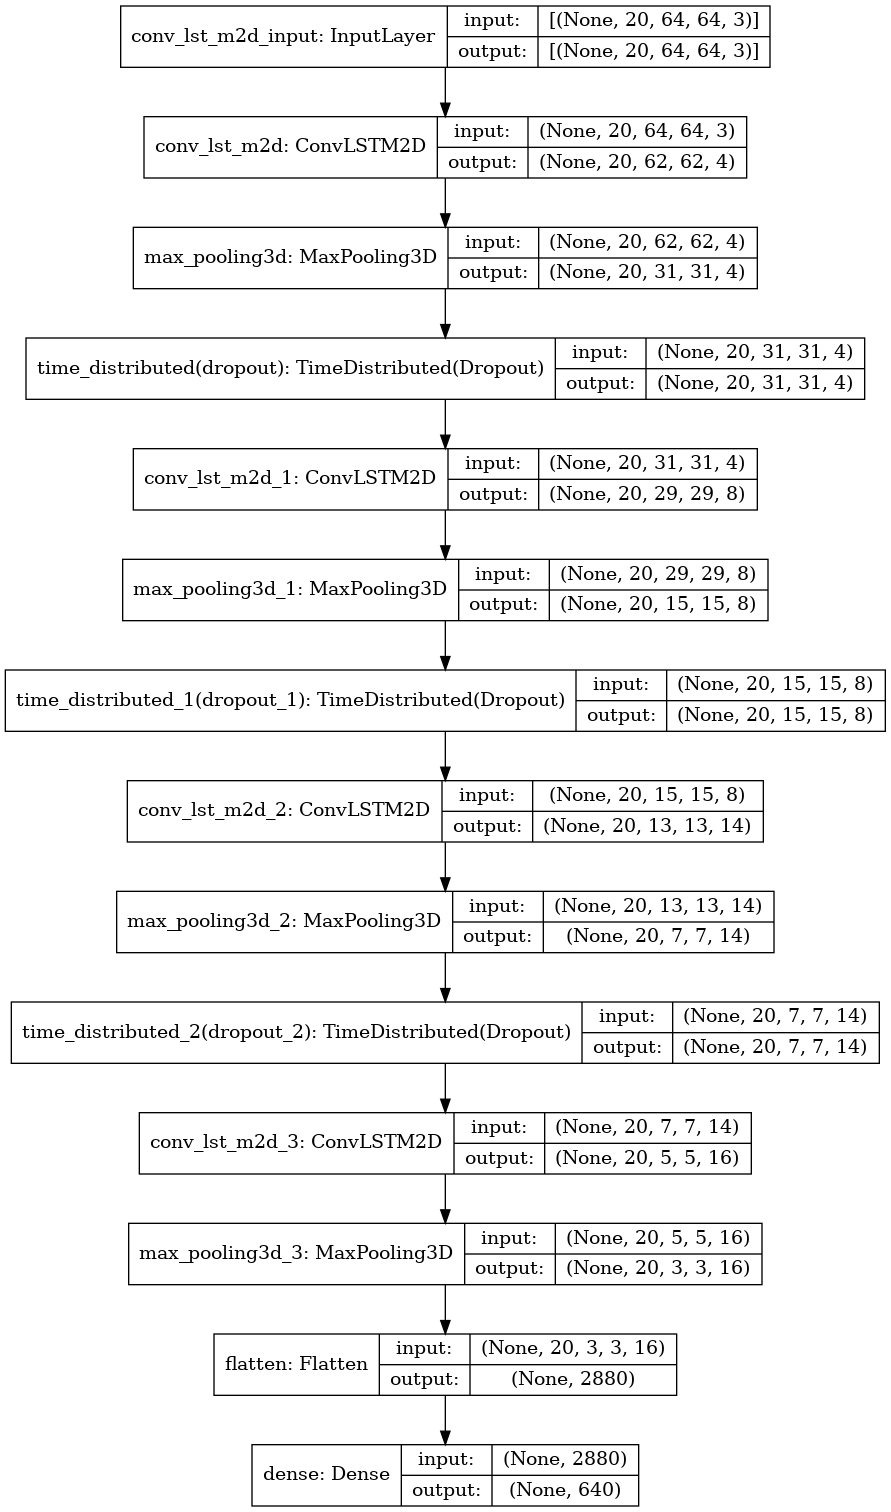

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     
                                                     callbacks = [early_stopping_callback])

2022-05-03 12:45:06.420927: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 589824000 exceeds 10% of free system memory.
2022-05-03 12:45:07.016249: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 589824000 exceeds 10% of free system memory.
2022-05-03 12:45:07.455883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-03 12:45:12.092537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:801] layout failed: Invalid argument: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'sequential/conv_lst_m2d_3/while/body/_675/sequential/conv_lst_m2d_3/while/convolution_6' -> 'sequential/conv_lst_m2d_3/while/body/_675/sequential/conv_lst_m2d_3/while/add_4', 'sequential/conv_lst_m2d_3/while/body/_675/sequential/conv_lst_m2d_3/while/clip_by_value' -> 'sequential/conv_lst_m2d_3/while/body/_675/sequential/conv_lst_m2d_3/while/mul_7', 'sequential/conv_lst_m2d_3/while/body/_675/sequential/conv_lst_m2d_3/while/mul_6' -> 'sequential/conv_lst_m2d_3/while/body/_675/sequential/conv_lst_m2d_3/while/add_5', 'sequential/conv_lst_m2d_3/while/body/_675/sequential/conv_lst_m2d_3/while/clip_by_value_2' -> 'sequential/conv_lst_m2d_3/while/body/_675/sequential/conv_lst_m2d_3/while/mul_9', 'sequential/conv_lst_m2d_2/while/body/_447/sequential/conv_lst_m2d_2/while/clip_by_value_2' -> 'seque

150/150 [==============================] - 57s 303ms/step - loss: 5.1523 - accuracy: 0.0000e+00 - val_loss: 4.9333 - val_accuracy: 0.0000e+00
Epoch 2/50
150/150 [==============================] - 46s 304ms/step - loss: 3.5904 - accuracy: 0.0017 - val_loss: 6.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
150/150 [==============================] - 47s 316ms/step - loss: 3.3230 - accuracy: 0.0000e+00 - val_loss: 5.3607 - val_accuracy: 0.0000e+00
Epoch 4/50
150/150 [==============================] - 47s 314ms/step - loss: 3.1952 - accuracy: 0.0000e+00 - val_loss: 5.3827 - val_accuracy: 0.0000e+00
Epoch 5/50
150/150 [==============================] - 48s 319ms/step - loss: 3.1102 - accuracy: 0.0000e+00 - val_loss: 5.2719 - val_accuracy: 0.0000e+00
Epoch 6/50
150/150 [==============================] - 48s 318ms/step - loss: 3.2689 - accuracy: 0.0000e+00 - val_loss: 5.8566 - val_accuracy: 0.0000e+00
Epoch 7/50
150/150 [==============================] - 47s 316ms/step - loss: 3.1478 - accuracy: 0

#### **<font style="color:#205375">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

2022-05-03 13:14:59.141483: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 246743040 exceeds 10% of free system memory.


8/8 [==============================] - 1s 87ms/step - loss: 4.7704 - accuracy: 0.0040




#### **<font style="color:#205375">Save the Model</font>**

Now we will save the model to avoid training it from scratch every time we need the model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### **<font style="color:#205375">Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

## **<font style="color:#112B3C">LRCN Approach</font>**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video. 


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>


You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------) by Jeff Donahue (CVPR 2015), to learn more about this architecture.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot. 

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

### **<font style="color:#205375">Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(NB_CLASSES, activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 20, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 20, 4, 4, 64)     

#### **<font style="color:#205375">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:#205375">Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
150/150 [==============================] - 4s 12ms/step - loss: 2.9462 - accuracy: 0.0017 - val_loss: 2.9316 - val_accuracy: 0.0000e+00
Epoch 2/70
150/150 [==============================] - 1s 8ms/step - loss: 2.5133 - accuracy: 0.0017 - val_loss: 3.1808 - val_accuracy: 0.0000e+00
Epoch 3/70
150/150 [==============================] - 1s 8ms/step - loss: 2.4316 - accuracy: 0.0033 - val_loss: 3.3436 - val_accuracy: 0.0000e+00
Epoch 4/70
150/150 [==============================] - 1s 8ms/step - loss: 2.4117 - accuracy: 0.0033 - val_loss: 3.4475 - val_accuracy: 0.0000e+00
Epoch 5/70
150/150 [==============================] - 1s 8ms/step - loss: 2.4039 - accuracy: 0.0033 - val_loss: 3.5195 - val_accuracy: 0.0000e+00
Epoch 6/70
150/150 [==============================] - 1s 8ms/step - loss: 2.4011 - accuracy: 0.0000e+00 - val_loss: 3.5712 - val_accuracy: 0.0000e+00
Epoch 7/70
150/150 [==============================] - 1s 9ms/step - loss: 2.4005 - accuracy: 0.0000e+00 - val_loss: 3.6

#### **<font style="color:205375">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

8/8 [==============================] - 0s 26ms/step - loss: 2.8572 - accuracy: 0.0000e+00


#### **<font style="color:#205375">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:#205375">Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **<font style="color:#112B3C">Test the Best Performing Model</font>**

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we will put the `LRCN` model to test on some youtube videos. 

### **<font style="color:#205375">Create a Function to Download YouTube Videos:</font>**

We will create a function **`download_youtube_videos()`** to download the YouTube videos first using **`pafy`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

### **<font style="color:#205375">Download a Test Video:</font>**

Now we will utilize the function **`download_youtube_videos()`** created above to download a youtube video on which the `LRCN` model will be tested.

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=Ebk5o9aU2VM', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

### **<font style="color:#205375">Create a Function To Perform Action Recognition on Videos</font>**

Next, we will create a function **`predict_on_video()`** that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform ASL on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the ASL is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

### **<font style="color:#205375">Perform Action Recognition on the Test Video</font>**

Now we will utilize the function **`predict_on_video()`** created above to perform action recognition on the test video we had downloaded using the function **`download_youtube_videos()`** and display the output video with the predicted action overlayed on it.

In [ ]:
#!wget install https://files.pythonhosted.org/packages/18/54/01a8c4e35c75ca9724d19a7e4de9dc23f0ceb8769102c7de056113af61c3/moviepy-1.0.3.tar.gz 

In [ ]:
pip install setuptools 

In [ ]:
from moviepy.editor import VideoFileClip

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
#output_video_file_path = f'{DATASET_DIR}/69241-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
#predict_on_video(f'{DATASET_DIR}/69241.mp4', output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### **<font style="color:#205375">Create a Function To Perform a Single Prediction on Videos</font>**


Now let's create a function that will perform a single prediction for the complete videos. We will extract evenly distributed **N** **`(SEQUENCE_LENGTH)`** frames from the entire video and pass them to the `LRCN` model. This approach is really useful when you are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.  

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

### **<font style="color:205375">Perform Single Prediction on a Test Video</font>**

Now we will utilize the function **`predict_single_action()`** created above to perform a single prediction on a complete youtube test video that we will download using the function **`download_youtube_videos()`**, we had created above.

In [ ]:
# Download the youtube video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=Ebk5o9aU2VM', test_videos_directory)

# Construct tihe nput youtube video path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()


Action Predicted: thin
Confidence: 0.013610361143946648
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
